In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Function to load the entire dataset from a CSV file and create a DataLoader
def load_dataloader_from_csv(csv_file, batch_size=128, img_shape=(1, 32, 32)):
    df = pd.read_csv(csv_file)

    # Separate the features (image data) and labels
    labels = df['label'].values
    features = df.drop(columns=['label']).values

    # Reshape the features back into the original image shape
    features = features.reshape(-1, *img_shape)

    # Convert to PyTorch tensors
    data_tensors = torch.tensor(features, dtype=torch.float32)
    label_tensors = torch.tensor(labels, dtype=torch.long)

    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(data_tensors, label_tensors)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return data_loader

### Adjust data path

In [3]:
DATA_PATH = '../dataset/'

In [4]:

train_loader = load_dataloader_from_csv(f"{DATA_PATH}train.csv", batch_size=128)
val_loader = load_dataloader_from_csv(f"{DATA_PATH}val.csv", batch_size=128)
test_loader = load_dataloader_from_csv(f"{DATA_PATH}test.csv", batch_size=128)

# Example: Iterate over the train_loader
for batch_idx, (data, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")


Batch 1:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 2:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 3:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 4:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 5:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 6:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 7:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 8:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 9:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 10:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 11:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
Batch 12:
Data shape: torch.Size([128, 1, 32, 32]), Labels shape: torch.Size([128])
B

In [5]:
import torch.nn as nn
import torch.optim as optim

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        # 1st convolution layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        
        # 2nd convolution layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        # 3rd convolution layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.bn1(x)
        
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.bn2(x)
        
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.bn3(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [11]:
def validate_model(model, val_loader, criterion):
    model.eval()  
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_val_loss, accuracy

In [12]:
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Wrap the train_loader with tqdm for a progress bar
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update running loss and update tqdm bar description
            running_loss += loss.item()
            if (i + 1) % 100 == 0:  # Update every 100 batches
                progress_bar.set_postfix({'Loss': running_loss / 100})
                running_loss = 0.0
            
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    print('Training finished')


In [13]:
def test_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Get predicted class
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total * 100
    print(f'Accuracy: {accuracy:.2f}%, Test Loss: {test_loss / len(test_loader):.4f}')


In [14]:
# Hyperparameters
num_classes = 29
num_epochs = 10
learning_rate = 0.001

model = ConvNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and Testing
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
test_model(model, test_loader, criterion)

Epoch 1/10: 100%|██████████| 544/544 [00:04<00:00, 129.34batch/s, Loss=0.897]


Validation Loss: 0.6666, Validation Accuracy: 78.00%


Epoch 2/10: 100%|██████████| 544/544 [00:03<00:00, 140.80batch/s, Loss=0.424]


Validation Loss: 0.3527, Validation Accuracy: 87.48%


Epoch 3/10: 100%|██████████| 544/544 [00:03<00:00, 140.41batch/s, Loss=0.289]


Validation Loss: 0.2867, Validation Accuracy: 90.07%


Epoch 4/10: 100%|██████████| 544/544 [00:03<00:00, 139.97batch/s, Loss=0.22] 


Validation Loss: 0.2505, Validation Accuracy: 91.45%


Epoch 5/10: 100%|██████████| 544/544 [00:03<00:00, 140.67batch/s, Loss=0.17] 


Validation Loss: 0.2486, Validation Accuracy: 91.99%


Epoch 6/10: 100%|██████████| 544/544 [00:03<00:00, 140.33batch/s, Loss=0.161]


Validation Loss: 0.3021, Validation Accuracy: 91.16%


Epoch 7/10: 100%|██████████| 544/544 [00:03<00:00, 139.71batch/s, Loss=0.131]


Validation Loss: 0.1616, Validation Accuracy: 94.94%


Epoch 8/10: 100%|██████████| 544/544 [00:03<00:00, 139.08batch/s, Loss=0.086]


Validation Loss: 0.1844, Validation Accuracy: 94.43%


Epoch 9/10: 100%|██████████| 544/544 [00:03<00:00, 137.95batch/s, Loss=0.103] 


Validation Loss: 0.1422, Validation Accuracy: 95.69%


Epoch 10/10: 100%|██████████| 544/544 [00:03<00:00, 138.22batch/s, Loss=0.0962]


Validation Loss: 0.2050, Validation Accuracy: 94.84%
Training finished
Accuracy: 95.01%, Test Loss: 0.1689


              precision    recall  f1-score   support

           0       0.97      0.86      0.92       300
           1       0.92      0.96      0.94       300
           2       1.00      0.99      0.99       300
           3       0.96      1.00      0.98       300
           4       0.94      0.91      0.93       300
           5       0.99      0.97      0.98       300
           6       0.95      0.92      0.93       300
           7       0.97      0.94      0.96       300
           8       0.99      0.97      0.98       300
           9       0.98      0.92      0.95       300
          10       0.98      0.96      0.97       300
          11       1.00      0.95      0.97       300
          12       0.93      0.96      0.94       300
          13       0.98      0.96      0.97       300
          14       0.95      0.99      0.97       300
          15       0.93      0.99      0.96       300
          16       0.96      0.97      0.96       300
          17       0.93    

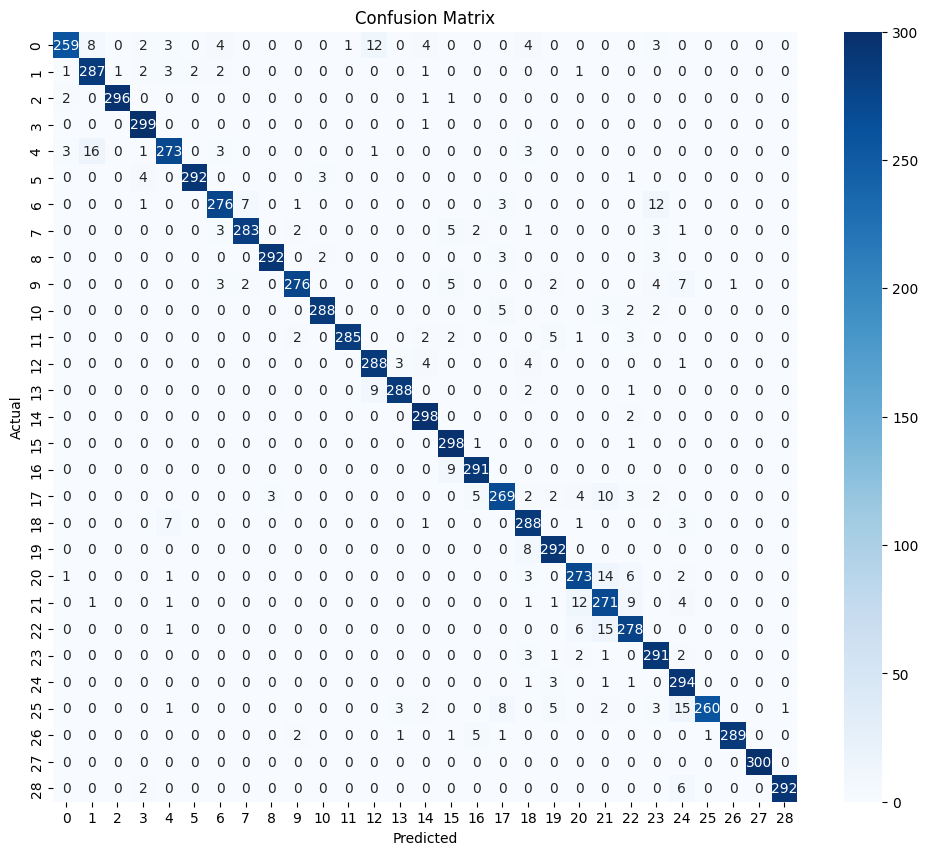

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `true_labels` and `predicted_labels` are your ground truth and model predictions
true_labels = []
predicted_labels = []

# Collect true and predicted labels for evaluation
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report)

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(12, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
